**Description**

- Class 0: OW (darkblue)
- Class 1: NI (lightblue)
- Class 2: GI (blue)
- Class 3: GWI (white)
- Class 4: ThinFI (silver)
- Class 5: MediumFI (gray)
- Class 6: ThickFI (purple)

# Classification by ConvLSTM

In [1]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap

# Load pre-trained model
model = tf.keras.models.load_model('convLSTM_model.keras')

# Load the pre-processed Sentinel-1 img
img = tiff.imread('subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif')

# image dimensions
h, w = img.shape[1], img.shape[2]

# 500x500 subset from the center of the img
subset_size = 500
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

subset_img = img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

depth = 6  # it's 6 because we have 6 time steps for the model, but the original image doesn't have 6 time steps, 
            #there is only 1. so I tricked it by writing it manually

# classify each part of the entire image area by overlapping
sea_ice_classes = np.zeros((subset_size, subset_size)) #initialize an array with zeros to store the classification results for each part of the image

patch_size = 32 #due to model, like the training samples 32x32
stride = 1  #stride which is the step size for sliding the window (1 pixel shift every time)

# timing
#calculate the total number of steps required to cover the entire image
total_steps = (subset_img.shape[1] - patch_size + 1) * (subset_img.shape[2] - patch_size + 1)
step_count = 0

#start timing - process to monitor performance
start_time = time.time()

# loops over the entire image with a sliding window approach
for i in range(0, subset_img.shape[1] - patch_size + 1, stride):
    for j in range(0, subset_img.shape[2] - patch_size + 1, stride):
        patch = subset_img[:, i:i+patch_size, j:j+patch_size] #extract 32x32 patches - HH and HV both included
        patch = np.expand_dims(patch, axis=0)  #bring it into (1, 2, 32, 32) shape
        patch = np.repeat(patch, depth, axis=0) #increase the time step size to 6 --- (6, 2, 32, 32)
        patch = np.transpose(patch, (0, 2, 3, 1))  #transpose to (6, 32, 32, 2)        
        patch = np.expand_dims(patch, axis=0)  #make it (1, 6, 32, 32, 2) like the model
        
        #classify using the model (verbose=0 prevents unnecessary output)
        output = model.predict(patch, verbose=0)
        predicted_class = np.argmax(output, axis=1) #the highest predicted probability
        sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel

        # timing - update and print progress
        step_count += 1
        if step_count % 1000 == 0 or step_count == total_steps:  #print every 1000 steps or at the end
            progress_percentage = (step_count / total_steps) * 100
            elapsed_time = time.time() - start_time
            print(f'Progress: {progress_percentage:.2f}% - Elapsed Time: {elapsed_time:.2f} seconds', end='\r')

# after the classification loop, remove the last 32 rows and columns to solve the problem. zeroes of the right and bottom edges
sea_ice_classes = sea_ice_classes[:-32, :-32]

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


C:\Users\co1st\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\co1st\AppData\Local\Temp\ipykernel_26412\1385732693.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel


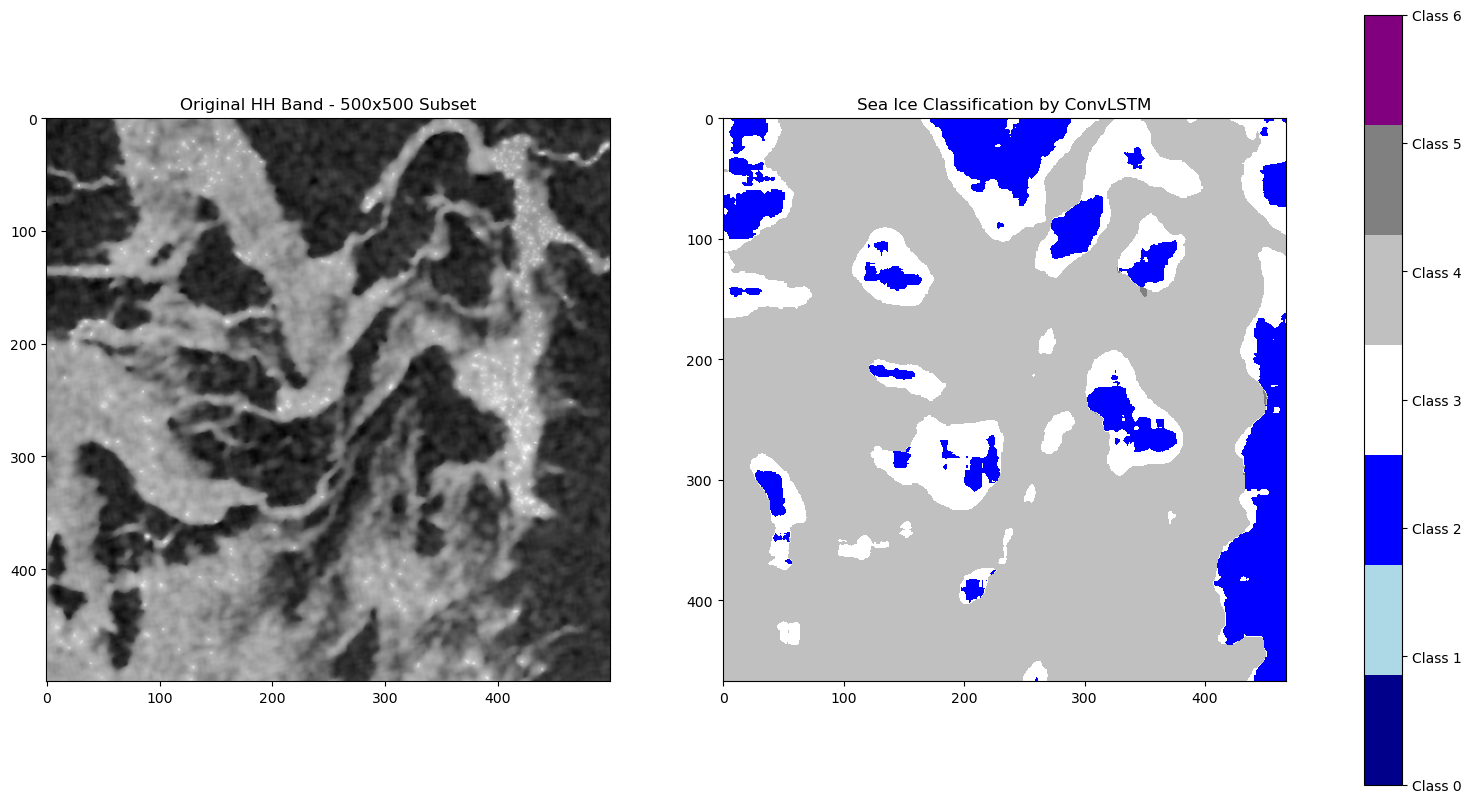

Class Percentages:
Class 2: 11.66%
Class 3: 15.05%
Class 4: 73.26%
Class 5: 0.03%


In [2]:
# Plot original and classified img

#special colors for each class
colors = ['darkblue', 'lightblue', 'blue', 'white', 'silver', 'gray', 'purple']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(subset_img[0], cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=6)
ax[1].set_title('Sea Ice Classification by ConvLSTM')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

#save the classified image
plt.imsave('cs_convLSTM.png', sea_ice_classes, cmap=cmap, vmin=0, vmax=6)


# Classification by 2D CNN - Conv2D
Everything in the code is the same, only the model is different

In [3]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap

# Load pre-trained model
model = tf.keras.models.load_model('conv2D_model.keras')

# Load the pre-processed Sentinel-1 img
img = tiff.imread('subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif')

# image dimensions
h, w = img.shape[1], img.shape[2]

# 500x500 subset from the center of the img
subset_size = 500
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

subset_img = img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

depth = 6  # it's 6 because we have 6 time steps for the model, but the original image doesn't have 6 time steps, 
            #there is only 1. so I tricked it by writing it manually

# classify each part of the entire image area by overlapping
sea_ice_classes = np.zeros((subset_size, subset_size)) #initialize an array with zeros to store the classification results for each part of the image

patch_size = 32 #due to model, like the training samples 32x32
stride = 1  #stride which is the step size for sliding the window (1 pixel shift every time)

# timing
#calculate the total number of steps required to cover the entire image
total_steps = (subset_img.shape[1] - patch_size + 1) * (subset_img.shape[2] - patch_size + 1)
step_count = 0

#start timing - process to monitor performance
start_time = time.time()

# loops over the entire image with a sliding window approach
for i in range(0, subset_img.shape[1] - patch_size + 1, stride):
    for j in range(0, subset_img.shape[2] - patch_size + 1, stride):
        patch = subset_img[:, i:i+patch_size, j:j+patch_size] #extract 32x32 patches - HH and HV both included
        patch = np.expand_dims(patch, axis=0)  #bring it into (1, 2, 32, 32) shape
        patch = np.repeat(patch, depth, axis=0) #increase the time step size to 6 --- (6, 2, 32, 32)
        patch = np.transpose(patch, (0, 2, 3, 1))  #transpose to (6, 32, 32, 2)        
        patch = np.expand_dims(patch, axis=0)  #make it (1, 6, 32, 32, 2) like the model
        
        #classify using the model (verbose=0 prevents unnecessary output)
        output = model.predict(patch, verbose=0)
        predicted_class = np.argmax(output, axis=1) #the highest predicted probability
        sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel

        # timing - update and print progress
        step_count += 1
        if step_count % 1000 == 0 or step_count == total_steps:  #print every 1000 steps or at the end
            progress_percentage = (step_count / total_steps) * 100
            elapsed_time = time.time() - start_time
            print(f'Progress: {progress_percentage:.2f}% - Elapsed Time: {elapsed_time:.2f} seconds', end='\r')

# after the classification loop, remove the last 32 rows and columns to solve the problem. zeroes of the right and bottom edges
sea_ice_classes = sea_ice_classes[:-32, :-32]

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


C:\Users\co1st\AppData\Local\Temp\ipykernel_26412\3770666763.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel


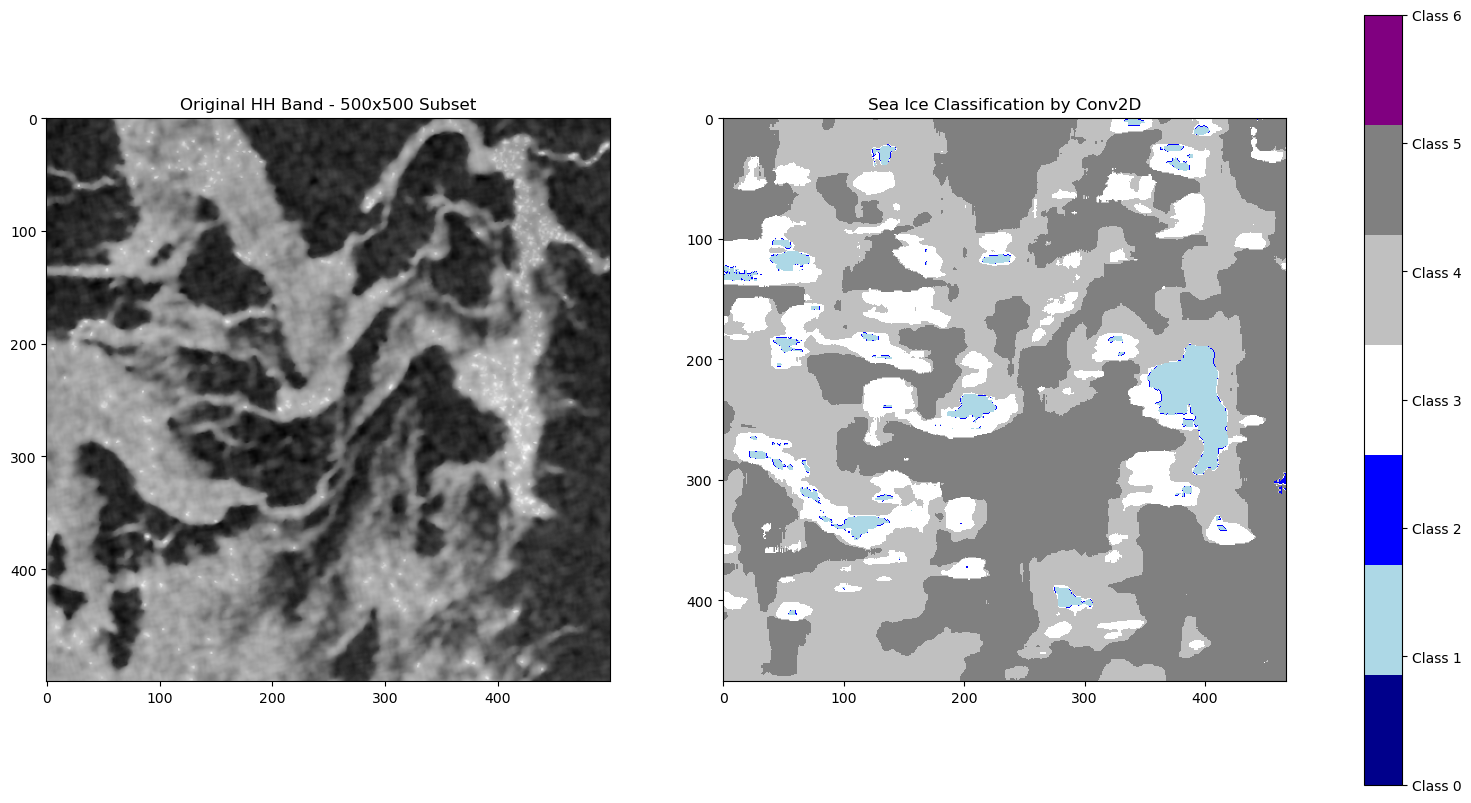

Class Percentages:
Class 1: 3.20%
Class 2: 0.04%
Class 3: 13.93%
Class 4: 36.94%
Class 5: 45.90%


In [4]:
# Plot original and classified img

#special colors for each class
colors = ['darkblue', 'lightblue', 'blue', 'white', 'silver', 'gray', 'purple']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(subset_img[0], cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=6)
ax[1].set_title('Sea Ice Classification by Conv2D')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

#save the classified image
plt.imsave('cs_conv2D.png', sea_ice_classes, cmap=cmap, vmin=0, vmax=6)


# Classification by 3D CNN
Everything in the code is the same, only the model is different

In [6]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap

# Load pre-trained model
model = tf.keras.models.load_model('3Dcnn_model.keras')

# Load the pre-processed Sentinel-1 img
img = tiff.imread('subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif')

# image dimensions
h, w = img.shape[1], img.shape[2]

# 500x500 subset from the center of the img
subset_size = 500
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

subset_img = img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

depth = 6  # it's 6 because we have 6 time steps for the model, but the original image doesn't have 6 time steps, 
            #there is only 1. so I tricked it by writing it manually

# classify each part of the entire image area by overlapping
sea_ice_classes = np.zeros((subset_size, subset_size)) #initialize an array with zeros to store the classification results for each part of the image

patch_size = 32 #due to model, like the training samples 32x32
stride = 1  #stride which is the step size for sliding the window (1 pixel shift every time)

# timing
#calculate the total number of steps required to cover the entire image
total_steps = (subset_img.shape[1] - patch_size + 1) * (subset_img.shape[2] - patch_size + 1)
step_count = 0

#start timing - process to monitor performance
start_time = time.time()

# loops over the entire image with a sliding window approach
for i in range(0, subset_img.shape[1] - patch_size + 1, stride):
    for j in range(0, subset_img.shape[2] - patch_size + 1, stride):
        patch = subset_img[:, i:i+patch_size, j:j+patch_size] #extract 32x32 patches - HH and HV both included
        patch = np.expand_dims(patch, axis=0)  #bring it into (1, 2, 32, 32) shape
        patch = np.repeat(patch, depth, axis=0) #increase the time step size to 6 --- (6, 2, 32, 32)
        patch = np.transpose(patch, (0, 2, 3, 1))  #transpose to (6, 32, 32, 2)        
        patch = np.expand_dims(patch, axis=0)  #make it (1, 6, 32, 32, 2) like the model
        
        #classify using the model (verbose=0 prevents unnecessary output)
        output = model.predict(patch, verbose=0)
        predicted_class = np.argmax(output, axis=1) #the highest predicted probability
        sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel

        # timing - update and print progress
        step_count += 1
        if step_count % 1000 == 0 or step_count == total_steps:  #print every 1000 steps or at the end
            progress_percentage = (step_count / total_steps) * 100
            elapsed_time = time.time() - start_time
            print(f'Progress: {progress_percentage:.2f}% - Elapsed Time: {elapsed_time:.2f} seconds', end='\r')

# after the classification loop, remove the last 32 rows and columns to solve the problem. zeroes of the right and bottom edges
sea_ice_classes = sea_ice_classes[:-32, :-32]

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


C:\Users\co1st\AppData\Local\Temp\ipykernel_14340\3008436224.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel


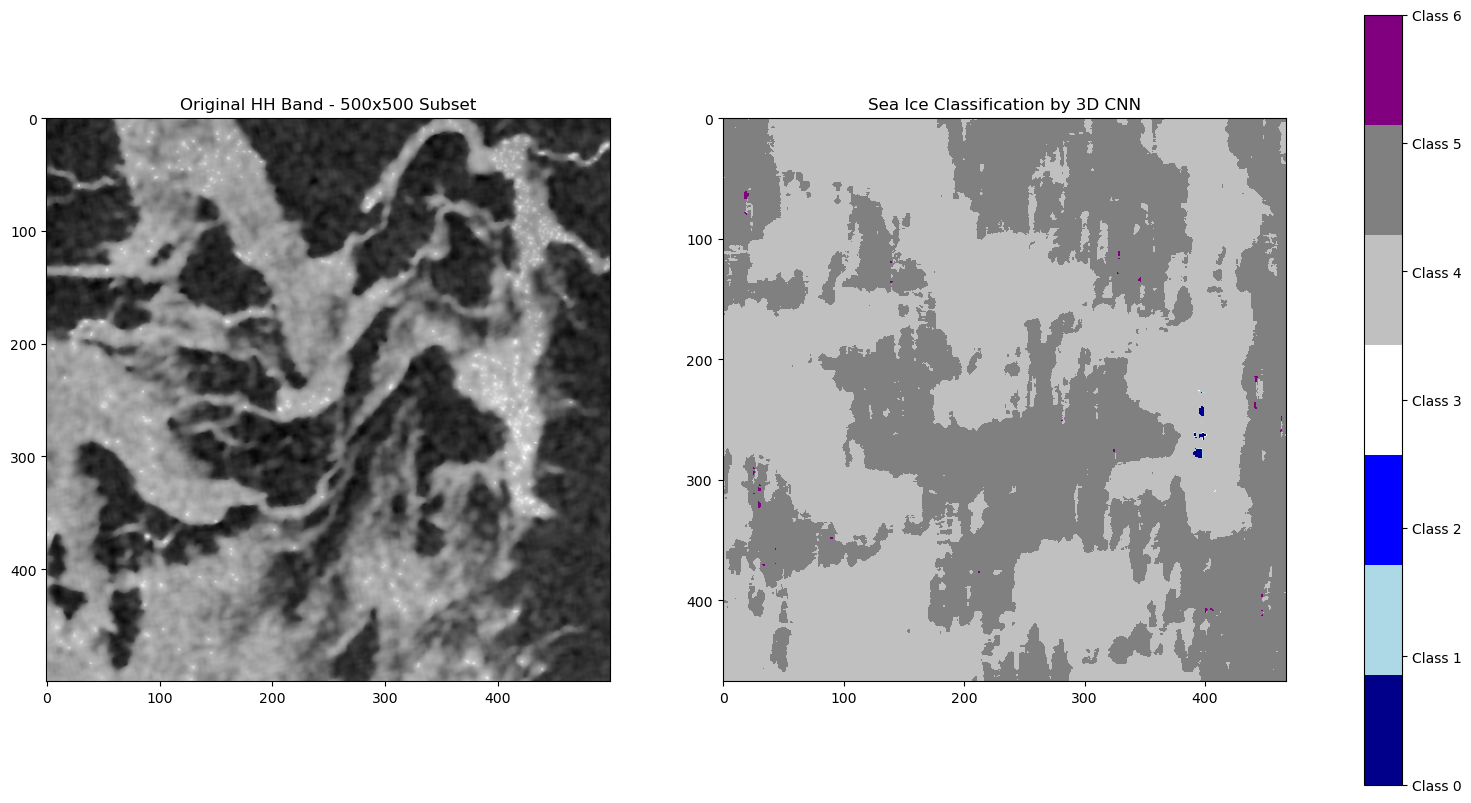

Class Percentages:
Class 0: 0.05%
Class 1: 0.00%
Class 4: 54.99%
Class 5: 44.92%
Class 6: 0.04%


In [8]:
# Plot original and classified img

#special colors for each class
colors = ['darkblue', 'lightblue', 'blue', 'white', 'silver', 'gray', 'purple']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(subset_img[0], cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=6)
ax[1].set_title('Sea Ice Classification by 3D CNN')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

#save the classified image
plt.imsave('cs_3Dcnn.png', sea_ice_classes, cmap=cmap, vmin=0, vmax=6)


# Classification by Mix of ConvLSTM & 3D CNN
Everything in the code is the same, only the model is different

In [9]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap

# Load pre-trained model
model = tf.keras.models.load_model('mixConv_model.keras')

# Load the pre-processed Sentinel-1 img
img = tiff.imread('subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif')

# image dimensions
h, w = img.shape[1], img.shape[2]

# 500x500 subset from the center of the img
subset_size = 500
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

subset_img = img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

depth = 6  # it's 6 because we have 6 time steps for the model, but the original image doesn't have 6 time steps, 
            #there is only 1. so I tricked it by writing it manually

# classify each part of the entire image area by overlapping
sea_ice_classes = np.zeros((subset_size, subset_size)) #initialize an array with zeros to store the classification results for each part of the image

patch_size = 32 #due to model, like the training samples 32x32
stride = 1  #stride which is the step size for sliding the window (1 pixel shift every time)

# timing
#calculate the total number of steps required to cover the entire image
total_steps = (subset_img.shape[1] - patch_size + 1) * (subset_img.shape[2] - patch_size + 1)
step_count = 0

#start timing - process to monitor performance
start_time = time.time()

# loops over the entire image with a sliding window approach
for i in range(0, subset_img.shape[1] - patch_size + 1, stride):
    for j in range(0, subset_img.shape[2] - patch_size + 1, stride):
        patch = subset_img[:, i:i+patch_size, j:j+patch_size] #extract 32x32 patches - HH and HV both included
        patch = np.expand_dims(patch, axis=0)  #bring it into (1, 2, 32, 32) shape
        patch = np.repeat(patch, depth, axis=0) #increase the time step size to 6 --- (6, 2, 32, 32)
        patch = np.transpose(patch, (0, 2, 3, 1))  #transpose to (6, 32, 32, 2)        
        patch = np.expand_dims(patch, axis=0)  #make it (1, 6, 32, 32, 2) like the model
        
        #classify using the model (verbose=0 prevents unnecessary output)
        output = model.predict(patch, verbose=0)
        predicted_class = np.argmax(output, axis=1) #the highest predicted probability
        sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel

        # timing - update and print progress
        step_count += 1
        if step_count % 1000 == 0 or step_count == total_steps:  #print every 1000 steps or at the end
            progress_percentage = (step_count / total_steps) * 100
            elapsed_time = time.time() - start_time
            print(f'Progress: {progress_percentage:.2f}% - Elapsed Time: {elapsed_time:.2f} seconds', end='\r')

# after the classification loop, remove the last 32 rows and columns to solve the problem. zeroes of the right and bottom edges
sea_ice_classes = sea_ice_classes[:-32, :-32]

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


C:\Users\co1st\AppData\Local\Temp\ipykernel_14340\54250083.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sea_ice_classes[i, j] = predicted_class #assign the predicted class to the corresponding pixel


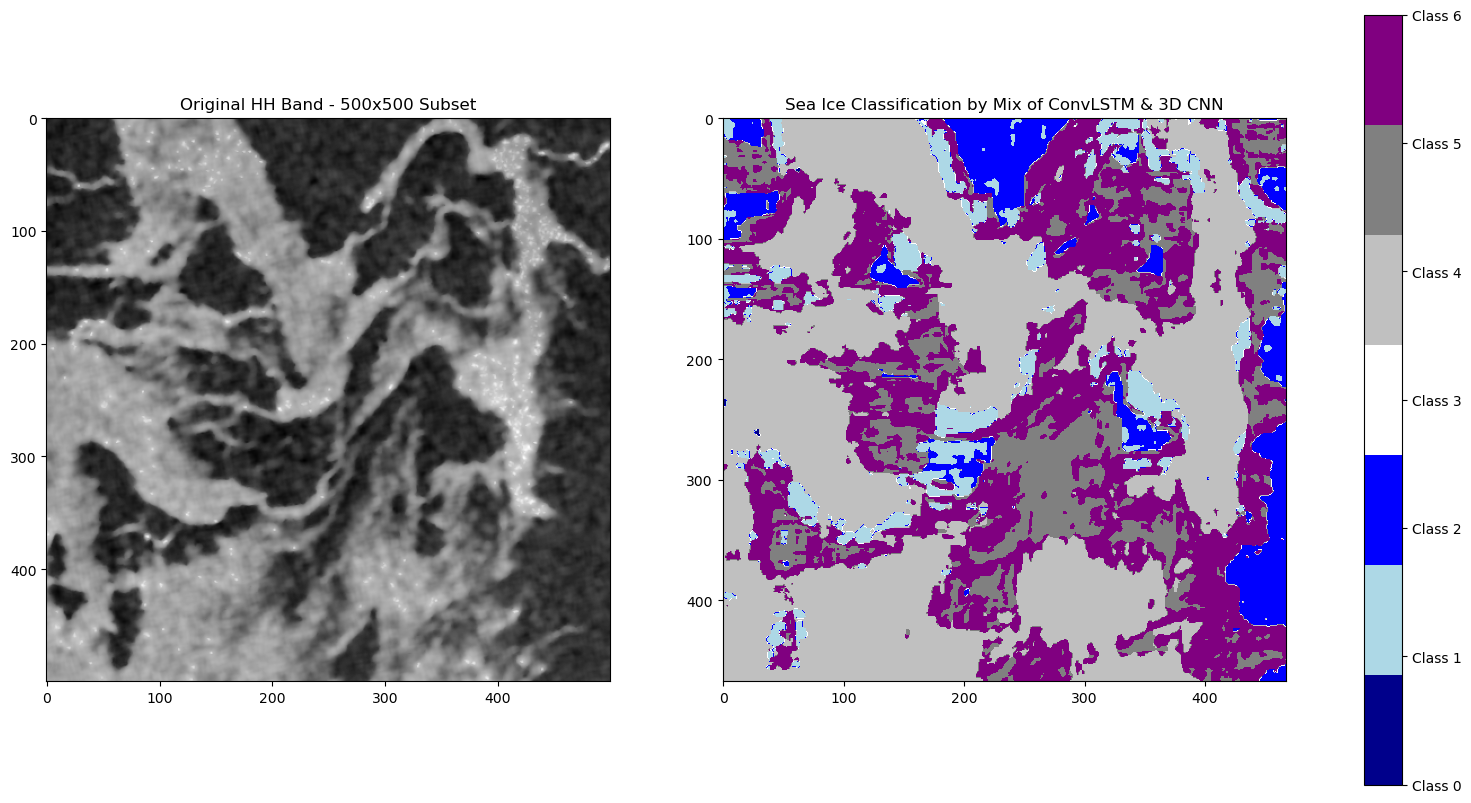

Class Percentages:
Class 0: 0.02%
Class 1: 6.57%
Class 2: 7.40%
Class 3: 0.02%
Class 4: 44.00%
Class 5: 13.80%
Class 6: 28.19%


In [10]:
# Plot original and classified img

#special colors for each class
colors = ['darkblue', 'lightblue', 'blue', 'white', 'silver', 'gray', 'purple']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(subset_img[0], cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=6)
ax[1].set_title('Sea Ice Classification by Mix of ConvLSTM & 3D CNN')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

#save the classified image
plt.imsave('cs_mixConv.png', sea_ice_classes, cmap=cmap, vmin=0, vmax=6)
